# A Simple Framework for Contrastive Learning of Visual Representations

- This notebook is to use the popular SimCLR framework in Tensorflow2.0 along with the strategies used in this paper ([SimCLR](https://arxiv.org/abs/2002.05709)), to learn generalised representations/features for images in a self supervised fashion on CIFAR10. 

# SimCLR :
1. Development of composition of data augmentation strategies to generate pairs of positive input data points that serve as an important component for discriminative learning. This could be considered as the hero element of the whole framework because defining the class of augmentations is clearly responsible towards defining the features the model will consider 2 distinguish between 2 items & features it will be invariant to while trying to find similarities between 2 items.
 
2. Introduction of a non linear projection head that creates a buffer between the output of the encoder network & the input to loss function. This was an elegant solution towards learning generalisable features.
 
3. Use of InfoNCE loss on feature similarity. This loss was introduced in [Improved Deep Metric Learning with
Multi-class N-pair Loss Objective](https://www.nec-labs.com/uploads/images/Department-Images/MediaAnalytics/papers/nips16_npairmetriclearning.pdf)  with a major contribution of a proposed objective function that allows joint comparison among more than 1 negative example & reduces the computational load of using only N pairs of examples, instead of (N+1)×N. The authors of SimCLR build on this loss function with the added innovation of usage of normalised encoded vectors & a temperature parameter to penalise hard negative samples.

In [1]:
! pip install imutils

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=944109d29344a38f54431959751eb3ab1eec3e9523a7c2032d9b1c32200ac7fc
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


# Basic Imports

In [2]:
# Basic Imports 

# Model mathematics
import math
import pandas as pd
import numpy as np 
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

# Plotting libraries
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Utilities
import datetime
import os,sys
import tempfile
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.append("/kaggle/input/helper-files")
import random 
import gc
import time
import functools
from imutils import paths
from tqdm import tqdm
from typing import Callable
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, f1_score

# SimCLR Losses (extra files, will be explained further in the notebook)
from semi_super_augPipe import preprocess_image
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers
import tensorflow_addons as tfa

# Random seed fixation for experiment result repitition
tf.random.set_seed(10)
np.random.seed(10)

print("Tensorflow version : ",tf.__version__)

# In-order run function decorators in tf2.0
tf.config.run_functions_eagerly(False)

# Load the TensorBoard notebook extension
%load_ext tensorboard

Tensorflow version :  2.6.2


In [3]:
# Setting the seeds
SEED = 0
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Paths & Constants

In [4]:
# These are the usual ipython objects
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Defining a function to list the memory consumed
# Only outputs variables taking at least 1MB space
def list_storage(inp_dir):
    # Get a sorted list of the objects and their sizes
    vars_defined = [x for x in inp_dir if not x.startswith('_') and x not in sys.modules and x not in ipython_vars]
    sto = sorted([(x, sys.getsizeof(globals().get(x))) for x in vars_defined], key=lambda x: x[1], reverse=True)
    sto = [(x[0], str(round((x[1] / 2**20), 2)) + ' MB') for x in sto if x[1] >= 2**20]
    print(tabulate(sto, headers = ['Variable', 'Storage (in MB)']))

# In order to use this function, use the below line of code
# list_storage(dir())

In [5]:
# Importing the Labelled Dataset
df_train = pd.read_csv("../input/cifar10/train_lab_x.csv")
y_train = pd.read_csv("../input/cifar10/train_lab_y.csv")

# Importing the Test Dataset
df_test = pd.read_csv("../input/cifar10/test_x.csv")
y_test = pd.read_csv("../input/cifar10/test_y.csv")

(40006, 3072) (40006, 1)
(40006, 3, 32, 32)
[0]
(40006, 32, 32, 3) (40006, 10)
(10000, 3072) (10000, 1)
(10000, 3, 32, 32)
(10000, 32, 32, 3) (10000, 10)
Tensorflow version :  2.6.2


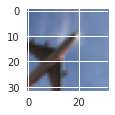

In [6]:
df_train = np.array(df_train)
y_train = np.array(y_train)
print(df_train.shape, y_train.shape)

# Reshaping the dataset
df_train = np.reshape(df_train, (-1, 3, 32, 32))
print(df_train.shape)

# Visualizing a single image
ind = 11
example = df_train[ind, : , : , : ]
example = example.transpose((1, 2, 0))
plt.figure(figsize=(1.5, 1.5))
plt.imshow(example)
print(y_train[ind])

# Creating a random permutation
perm = np.random.permutation(df_train.shape[0])

# Shuffling the training dataset
df_train = df_train[perm, : , : , : ]
y_train = y_train[perm]

# Reshaping, rescaling and one-hot encoding
df_train = np.transpose(np.array(df_train), (0, 2, 3, 1))
df_train = df_train / 255
y_train_oh = tf.one_hot(np.ravel(y_train), depth = 10)

print(df_train.shape, y_train_oh.shape)

df_test = np.array(df_test)
y_test = np.array(y_test)
print(df_test.shape, y_test.shape)

# Reshaping the dataset
df_test = np.reshape(df_test, (-1, 3, 32, 32))
print(df_test.shape)

# Reshaping, rescaling and one-hot encoding
df_test = np.transpose(np.array(df_test), (0, 2, 3, 1))
df_test = df_test / 255
y_test_oh = tf.one_hot(np.ravel(y_test), depth = 10)
print(df_test.shape, y_test_oh.shape)

# Random seed fixation for experiment result repitition
tf.random.set_seed(10)
np.random.seed(10)

print("Tensorflow version : ",tf.__version__)

# In-order run function decorators in tf2.0
tf.config.run_functions_eagerly(False)

In [7]:
# Image training properties 
IMG_H, IMG_W = (32, 32)

# How powerful you want the colour augmentations to be
color_jitter_strength = 0.3

# Minimum crop area you want
minimum_object_coverage = 0.7

# Range of crop area
area_range = (minimum_object_coverage, 1.0)
BATCH_SIZE = 32

# Helper code

In [8]:
cosine_sim_1d = tf.keras.losses.CosineSimilarity(axis=1, reduction=tf.keras.losses.Reduction.NONE)
cosine_sim_2d = tf.keras.losses.CosineSimilarity(axis=2, reduction=tf.keras.losses.Reduction.NONE)


def _cosine_simililarity_dim1(x, y):
    v = cosine_sim_1d(x, y)
    return v


def _cosine_simililarity_dim2(x, y):
    # x shape: (N, 1, C)
    # y shape: (1, 2N, C)
    # v shape: (N, 2N)
    v = cosine_sim_2d(tf.expand_dims(x, 1), tf.expand_dims(y, 0))
    return v


def _dot_simililarity_dim1(x, y):
    # x shape: (N, 1, C)
    # y shape: (N, C, 1)
    # v shape: (N, 1, 1)
    v = tf.matmul(tf.expand_dims(x, 1), tf.expand_dims(y, 2))
    return v


def _dot_simililarity_dim2(x, y):
    v = tf.tensordot(tf.expand_dims(x, 1), tf.expand_dims(tf.transpose(y), 0), axes=2)
    # x shape: (N, 1, C)
    # y shape: (1, C, 2N)
    # v shape: (N, 2N)
    return v

In [9]:
import functools

# Constants to control augmentation strength
FLAGS_color_jitter_strength = 0.5
FLAGS_min_object_covered = 0.3 # min area in the specified boudning box to cover
FLAGS_area_range = (0.3, 1.0) # the cropped area must contain a fraction of the supplied image within this range

# pipe for random rotations
aug_layers = tf.keras.Sequential([tf.keras.layers.RandomRotation(0.1),])

def set_aug_strength_value(cjs, m_obj_cov, a_range): 
    """
    Function to setup the value of the augmentation variables
    Arguments:
        cjs : (float) strength of color jittering to apply to vary the color histograms
        m_obj_cov : (float)  min area in the specified boudning box to cover
        a_range : (tuple) the cropped area must contain a fraction of the supplied image within this range
    Returns :
        None, only sets the values
    """
    global FLAGS_color_jitter_strength
    FLAGS_color_jitter_strength = cjs

    global FLAGS_min_object_covered
    FLAGS_min_object_covered = m_obj_cov

    global FLAGS_area_range
    FLAGS_area_range = a_range

def random_apply(func, p, x):
    """
    Function that acts as a wrapper to apply augmentations randomly
    -> tf cond is a functions whose first argument is a predicate, when it is true then it returns first function (i.e. apply augmentation) else dont apply augmentation
    -> tf less return true if arg1 < arg2 
    -> tf random uniform picks a number between 0 & 1 randomly
    Arguments:
        func : (function) augmentation to apply randomly
        p : (float) probability value [0-1]
        x : (tf.image) input type
    Returns:
        image after applying the specified augmentation stochastically
    """ 
    return tf.cond(tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32), tf.cast(p, tf.float32)),
                    lambda: func(x),
                    lambda: x)

def distorted_bounding_box_crop(image, 
                                bbox, 
                                min_object_covered=0.1, 
                                aspect_ratio_range=(0.75, 1.33), 
                                area_range=(0.05, 1.0), 
                                max_attempts=100, 
                                scope=None):
    """
    Generates cropped_image using one of the bboxes randomly distorted.
    See `tf.image.sample_distorted_bounding_box` for more documentation.
    Arguments:
        image: `Tensor` of image data.
        bbox: `Tensor` of bounding boxes arranged `[1, num_boxes, coords]` where each coordinate is [0, 1) and the coordinates are arranged
                as `[ymin, xmin, ymax, xmax]`. If num_boxes is 0 then use the whole image.
        min_object_covered: An optional `float`. Defaults to `0.1`. The cropped area of the image must contain at least this fraction of any bounding box supplied.
        aspect_ratio_range: An optional list of `float`s. The cropped area of the image must have an aspect ratio = width / height within this range.
        area_range: An optional list of `float`s. The cropped area of the image must contain a fraction of the supplied image within in this range.
        max_attempts: An optional `int`. Number of attempts at generating a cropped region of the image of the specified constraints. After `max_attempts` failures, return the entire image.
        scope: Optional `str` for name scope.
    Returns:
        (cropped image `Tensor`, distorted bbox `Tensor`).
        """
    with tf.name_scope('distorted_bounding_box_crop'):
        shape = tf.shape(image)
        sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(shape,
                                                                                bounding_boxes=bbox,
                                                                                min_object_covered=min_object_covered,
                                                                                aspect_ratio_range=aspect_ratio_range,
                                                                                area_range=area_range,
                                                                                max_attempts=max_attempts,
                                                                                use_image_if_no_bounding_boxes=True)
        bbox_begin, bbox_size, _ = sample_distorted_bounding_box

        # Crop the image to the specified bounding box.
        offset_y, offset_x, _ = tf.unstack(bbox_begin)
        target_height, target_width, _ = tf.unstack(bbox_size)
        image = tf.image.crop_to_bounding_box(image, offset_y, offset_x, target_height, target_width)
        return image

def crop_and_resize(image, height, width):
    """
    Make a random crop and resize it to height `height` and width `width`.
    Arguments:
        image: Tensor representing the image.
        height: Desired image height.
        width: Desired image width.
    Returns:
        A `height` x `width` x channels Tensor holding a random crop of `image`.
    """
    
    bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    aspect_ratio = width / height
    # Flag values are the global ones & they are set by set_aug_strength_value
    image = distorted_bounding_box_crop(image,
                                        bbox,
                                        min_object_covered = FLAGS_min_object_covered ,
                                        aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
                                        area_range= FLAGS_area_range,
                                        max_attempts=100,
                                        scope=None)
    
    return tf.image.resize([image], [height, width], method = "bicubic")[0]

def random_crop_with_resize(image, height, width, p=1.0):
    """
    Randomly crop and resize an image.
    Arguments:
        image: `Tensor` representing an image of arbitrary size.
        height: Height of output image.
        width: Width of output image.
        p: Probability of applying this transformation.
    Returns:
        A preprocessed image `Tensor`.
    """
    def _transform(image):  # pylint: disable=missing-docstring
        image = crop_and_resize(image, height, width)
        return image
    
    return random_apply(_transform, p=p, x=image)

def color_distortion(image, s=1.0):
    
    # image is a tensor with value range in [0, 1].
    # s is the strength of color distortion.
    def color_jitter(x):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x

    def color_drop(x):
        image = tf.image.rgb_to_grayscale(x)
        image = tf.tile(image, [1, 1, 3])
        return image
    
    def non_lin_wrap(x):
        
        input_img = tf.image.convert_image_dtype(tf.expand_dims(x, 0), tf.dtypes.float32)
        flow_shape = [1, input_img.shape[1], input_img.shape[2], 2]
        init_flows = tf.random.normal(shape=flow_shape) * 2.0
        dense_img_warp = tfa.image.dense_image_warp(input_img, init_flows)
        dense_img_warp = tf.squeeze(dense_img_warp, 0)
        return dense_img_warp
        
    def random_rotate(x):
        # either apply 90 rotation or +/- 10 skew
        return tf.cond(tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32), tf.cast(0.5, tf.float32)), 
                       true_fn = lambda : tf.image.rot90(x, k=1), 
                       false_fn = lambda : aug_layers(x))
    
    def random_gauss_noise(x):
        noise = tf.random.normal(shape = (x.shape), mean = 0.0, stddev = 0.05, dtype = tf.float32) 
        return x + noise 
        
    def gauss_filter(x):
        return tfa.image.gaussian_filter2d(x, (10,10), sigma = 6.0)
    
    def channel_randomisation(x):
        channels = tf.unstack (x, axis=-1)
        c_order = tf.random.shuffle([0,1,2])
        
        return tf.stack([tf.gather(channels, c_order[0]), 
                         tf.gather(channels, c_order[1]), 
                         tf.gather(channels, c_order[2])], 
                         axis=-1)
    
    def random_overlay_color_masks(x):
        r = tf.random.uniform(shape=[], minval=0, maxval=1)
        g = tf.random.uniform(shape=[], minval=0, maxval=1)
        b = tf.random.uniform(shape=[], minval=0, maxval=1)
        r_channel = tf.fill([x.shape[0],x.shape[1]], r) 
        g_channel = tf.fill([x.shape[0],x.shape[1]], g) 
        b_channel = tf.fill([x.shape[0],x.shape[1]], b)
        
        mask_img = tf.stack([r_channel, g_channel, b_channel], axis=-1)
        
        alpha = tf.random.uniform(shape=[], minval=0.7, maxval=1)
        beta = tf.random.uniform(shape=[], minval=0.1, maxval=0.5)
        return alpha*x + beta * mask_img 

    # randomly apply transformation with probability p.
    image = random_apply(color_jitter, p=0.8, x = image)
    image = random_apply(color_drop, p=0.4, x = image)
    image = random_apply(non_lin_wrap, p=0.1, x = image)
    image = random_apply(gauss_filter, p = 0.1, x = image)
    image = random_apply(random_rotate, p = 0.2, x = image)
    image = random_apply(channel_randomisation, p = 0.2, x = image)
    image = random_apply(random_gauss_noise, p = 0.2, x = image)
    image = random_apply(random_overlay_color_masks, p = 0.4, x = image)
    return image

def preprocess_for_train(image, 
                        height, 
                        width, 
                        color_distort = True, 
                        crop = True):
    
    """
    Preprocesses the given image for training.
    Arguments:
        image  : (tf.image) representing an image of arbitrary size.
        height : (int) height of the image to be returned
        width  : (int) width of the image to be returned
        color_distort : (bool) whether to apply the color distortion.
        crop :(bool) Whether to crop the image.
    Returns:
        A preprocessed image `Tensor`.
    """

    # Applying image crop randomly 
    if crop:
        image = random_crop_with_resize(image, height, width)
    

    # Applying color distortion, it becomes necessary when dealing with random crops
    if color_distort:
        image = color_distortion(image, s = FLAGS_color_jitter_strength)
    
    # Safely reshaping the image for batch formation & model inference
    image = tf.reshape(image, [height, width, 3])

    # Clipping steps for image normalisation
    image = tf.clip_by_value(image, 0., 1.)

    return image

def preprocess_image(image, 
                     height, 
                     width, 
                     color_distort = True, 
                     cjs = 0.5, 
                     m_obj_cov = 0.3, 
                     a_range = (0.3,1.0)):
    """
    Preprocesses the given image.
    Arguments:
        image  : (numpy array) representing an image of arbitrary size.
        height : (int) height of the image to be returned
        width  : (int) width of the image to be returned
        color_distort : (bool) whether to apply the color distortion.
        cjs : (float) color jitter strength & the default value is the base line we have
        m_obj_cov : (float)  min area in the specified boudning box to cover
        a_range : (tuple) the cropped area must contain a fraction of the supplied image within this range
    Returns:
        A preprocessed image tf.image of range [0, 1] normalised.
        """

    # updating global values of the augmentation strength control parameters
    set_aug_strength_value(cjs, m_obj_cov, a_range)
    # Np to tensor & data-type setup
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    return preprocess_for_train(image, 
                                height, 
                                width, 
                                color_distort = True,
                                crop = True)
 

In [10]:
# Helper functions
@tf.function
def input_image_loader(image):
    image_norm = tf.image.convert_image_dtype(image, tf.float32)
    
    # The IMG_H & IMG_W are constants that will be read only once during graph tracing step
    image_norm = tf.image.resize(image_norm, size=[IMG_H, IMG_W])
    

    aug_image_1 = preprocess_image(image = image_norm, 
                                    height = IMG_H, 
                                    width  = IMG_W, 
                                    cjs = color_jitter_strength,
                                    m_obj_cov = minimum_object_coverage,
                                    a_range = area_range)

    aug_image_2 = preprocess_image(image = image_norm, 
                                    height = IMG_H, 
                                    width  = IMG_W, 
                                    cjs = color_jitter_strength,
                                    m_obj_cov = minimum_object_coverage,
                                    a_range = area_range)
    # view 1 & view 2
    return aug_image_1, aug_image_2

In [11]:
# TFDS
train_tensor = tf.data.Dataset.from_tensor_slices(df_train)
train_ds_shuffled = train_tensor.shuffle(len(train_tensor))
final_train_ds = (train_ds_shuffled
                .map(input_image_loader, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(BATCH_SIZE, drop_remainder=True)
                .prefetch(tf.data.experimental.AUTOTUNE))

# Visualisation

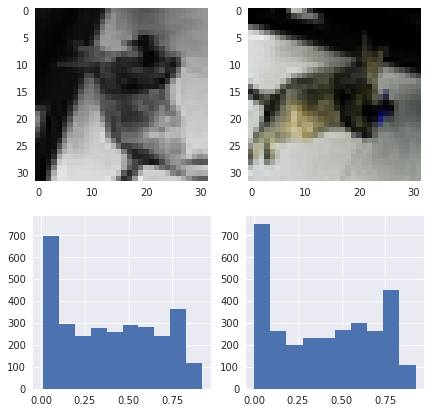

In [12]:
for batch in final_train_ds.take(1):
    pass

image_to_viz = 3
plt.figure(figsize=(7, 7))
ax1 = plt.subplot(2, 2, 1)
plt.imshow(batch[0][image_to_viz].numpy().astype('float32'), interpolation = 'none', vmin = 0, vmax = 1)
ax1.grid(False)
ax2 = plt.subplot(2, 2, 2)
plt.imshow(batch[1][image_to_viz].numpy().astype('float32'), interpolation = 'none', vmin = 0, vmax = 1)
ax2.grid(False)

ax3 = plt.subplot(2, 2, 3)
plt.hist(batch[0][image_to_viz].numpy().ravel())
ax4 = plt.subplot(2, 2, 4, sharey = ax3, sharex=ax3)
plt.hist(batch[1][image_to_viz].numpy().ravel())
plt.show()

# Model Building

## 1. Model helper functions

In [13]:
# adding l2 reg
def add_regularization(model, regularizer = tf.keras.regularizers.l2(0.0001)):
    """
    Helper function to add l2 regularisation to each layer of a either a preTrained or 
    randomly initialised built in model
    Arguments:
        model : (keras.model) input model 
        regularizer : ( tf.keras.regularizers.l2) object from keras that defines a l2 regularizer
    Returns:
        model : all layers contain the "regularizer" object & incase we pass a pretrained model then the 
                original weights are preserved
    """

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
        print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
        return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

# Architecture utils
def get_simclr(hidden_1, 
               hidden_2, 
               l2_penalty = 10e-6):
    """
    Main function to define the entire network backbone to train
    Arguments:
        hidden_1-2 : (int) variable to define number of neurons in the projection head dense layer
        l2_penalty : (float) to define the amount of l2 penalty applied to each layer's weights
    Returns:
        final_model : (tf.keras.Model) final model that will be trained 
    """
    
    # encoder network
    base_model = tf.keras.applications.ResNet50V2(include_top = False, 
                                                  weights = None, 
                                                  input_shape = (IMG_H, IMG_W, 3))
    
    # defining l2 regularization
    regularizer = tf.keras.regularizers.l2(l2_penalty)
    reg_base_model = add_regularization(base_model,regularizer)
    reg_base_model.trainable = True

    # Joining the entire pipeline using functional API
    inputs = Input((IMG_H, IMG_W, 3))
    h = reg_base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)
    
    # Non linear projection layer to improve the quality of embeddings being produced
    projection_1 = Dense(hidden_1, kernel_regularizer = regularizer)(h)
    projection_1 = tf.keras.layers.BatchNormalization()(projection_1)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2, kernel_regularizer = regularizer)(projection_1)
    projection_2 = tf.keras.layers.BatchNormalization()(projection_2)
    projection_2 = Activation("relu")(projection_2)

    # Final Model
    final_model = Model(inputs, projection_2)
    return final_model

def simclr_model(input_shape):
    """
    Main function to define the entire network backbone to train
    Arguments:
        hidden_1-2 : (int) variable to define number of neurons in the projection head dense layer
        l2_penalty : (float) to define the amount of l2 penalty applied to each layer's weights
    Returns:
        final_model : (tf.keras.Model) final model that will be trained 
    """
    
#     # encoder network
#     base_model = tf.keras.applications.ResNet50V2(include_top = False, 
#                                                   weights = None, 
#                                                   input_shape = (IMG_H, IMG_W, 3))
    
#     # defining l2 regularization
#     regularizer = tf.keras.regularizers.l2(l2_penalty)
#     reg_base_model = add_regularization(base_model,regularizer)
#     reg_base_model.trainable = True

#     # Joining the entire pipeline using functional API
#     inputs = Input((IMG_H, IMG_W, 3))
#     h = reg_base_model(inputs, training=True)
#     h = GlobalAveragePooling2D()(h)
    
#     # Non linear projection layer to improve the quality of embeddings being produced
#     projection_1 = Dense(hidden_1, kernel_regularizer = regularizer)(h)
#     projection_1 = tf.keras.layers.BatchNormalization()(projection_1)
#     projection_1 = Activation("relu")(projection_1)
#     projection_2 = Dense(hidden_2, kernel_regularizer = regularizer)(projection_1)
#     projection_2 = tf.keras.layers.BatchNormalization()(projection_2)
#     projection_2 = Activation("relu")(projection_2)

    input_img = tf.keras.Input(shape = input_shape)
    
    Z1 = tfl.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(input_img)
    B1 = tfl.BatchNormalization(axis=-1)(Z1)
    Z2 = tfl.Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu')(B1)
    B2 = tfl.BatchNormalization(axis=-1)(Z2)
    P1 = tfl.MaxPool2D(pool_size=2, strides=2, padding='valid')(B2)
    D1 = tfl.Dropout(0.25)(P1)
    # (16, 16, 16)
    
    Z3 = tfl.Conv2D(32, kernel_size=2, strides=1, padding='valid', activation='relu')(D1)
    B3 = tfl.BatchNormalization(axis=-1)(Z3)
    Z4 = tfl.Conv2D(32, kernel_size=2, strides=1, padding='valid', activation='relu')(B3)
    B4 = tfl.BatchNormalization(axis=-1)(Z4)
    P2 = tfl.MaxPool2D(pool_size=2, strides=2, padding='valid')(B4)
    D2 = tfl.Dropout(0.25)(P2)
    # (7, 7, 32)
    
    F1 = tfl.Flatten()(D2)
    Den1 = tfl.Dense(256, activation='relu')(F1)
    Drop1 = tfl.Dropout(0.25)(Den1)
    Den2 = tfl.Dense(64, activation='relu')(Drop1)
    Drop2 = tfl.Dropout(0.25)(Den2)
    outputs = tfl.Dense(10, activation='softmax')(Drop2)
    
    model = tf.keras.Model(inputs = input_img, outputs = outputs)
    return model

    # Final Model
    final_model = Model(inputs, outputs)
    return final_model

# 2. Defining a negative Mask 

This function has been define in the other files attached & the main goal of it is to define a mask when we compute loss of negative comparisons. Here is the output of this code visualised : 

**This negative mask will allow us to ignore the positive pairs in an augmented batch & help us focus only on the negative stuff !**

In [14]:
def get_negative_mask(batch_size):
    # return a mask that removes the similarity score of equal/similar images.
    # this function ensures that only distinct pair of images get their similarity scores
    # passed as negative examples
    negative_mask = np.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0
    return tf.constant(negative_mask)

In [15]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = get_negative_mask(BATCH_SIZE)

In [16]:
! rm -rf ./logs
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [17]:
@tf.function
def train_step(xis, 
               xjs, 
               model, 
               optimizer, 
               criterion, 
               temperature):

    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors : onto a unit hypersphere
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)
          
        # calculating over set of all positive pairs ( computing all numerators of softmax)
        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))

        # temperature scaling
        l_pos /= temperature
        
        # make the batch dimension 2*n
        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0
        for positives in [zis, zjs]:
            # computing similarity with a data point & all the possible negatives
            l_neg = sim_func_dim2(positives, negatives)
            
            # since each data point is its own class
            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)
            
            # using the negative mask to remove itself & its positve counterpart to compute negative sim
            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))

            # temperature scaling
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred = logits, y_true = labels)

        # since for every data point including its augmentation we compute the loss thus divide by 2*BatchSize
        loss = loss / (2 * BATCH_SIZE)
    
    # Compute & apply the gradients on traininable paramters of the model
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # updated model along with gradients so that we can visualise them on tensorboard.
    return loss, gradients

# 4. Train function

In [18]:
def train_simclr(model, 
                 train_dataset, 
                 optimizer, 
                 criterion,
                 temperature=0.1, 
                 epochs=100,
                 num_train_samples_viz = 5,
                 num_test_samples_viz = 2,
                metrics = 'accuracy'):
    
    """
      Training the model function
    """
    
 
    print("Starting training procedure .... : ")
    print("Number of steps per epoch : ",len(train_dataset))
    
    # To measure per epoch time taken
    t_start = time.time()
    
    # Visualisation lists
    lr_epoch = []
    epoch_wise_loss = []

    for epoch in range(0, epochs):
        
        # Reset loss collection each step
        step_wise_loss = []

        # Number of grad descent steps in 1 epoch
        num_train_steps = len(train_dataset) 

        # Picking up random batches & taking first image for input check
        random_batches_train = random.sample(range(len(train_dataset)),num_train_samples_viz)
        cnt = 0

        # Arrays for tensorboard visualisation
        random_collection_train_sample_1 = []
        random_collection_train_sample_2 = []
        gradArray = None
        loss = None 

        # Training loop
        for image_batch in tqdm(train_dataset):

            # Fetching both views for input
            a = image_batch[0]
            b = image_batch[1]

            # Train one batch
            loss, gradArray = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

            # Check whether to take image from this batch or not
            if cnt in random_batches_train:
                random_collection_train_sample_1.append(image_batch[0][0])
                random_collection_train_sample_2.append(image_batch[1][0])
            cnt+=1
        
        # Average loss throughout the whole process
        if not len(epoch_wise_loss):
            epoch_wise_loss.append(np.mean(step_wise_loss))
        else:
            # Adding the mean of previous ones
            mean_value = (np.sum(step_wise_loss) + epoch_wise_loss[-1]*(epoch)*num_train_steps)/((epoch+1)*num_train_steps)
            epoch_wise_loss.append(mean_value)
        
        # Printing the loss progression
        print("\n epoch: {} | train loss: {:.8f} | lr : {} | {:.4f} mins"
              .format(epoch + 1,epoch_wise_loss[-1],optimizer._decayed_lr(tf.float32).numpy(), (time.time()-t_start)/60.0))    
   
        # Appending the value of learning rate for warmup + cosine decay visualisation
        lr_epoch.append(optimizer._decayed_lr(tf.float32).numpy())
        
        # saving models 
        print("Saving Base Model.....")
        
        # Saving the entire model for checkpointing reasons
        model.save("./" + modelNameStr + ".h5")

        # saving the state of optimizer
        np.save("./" + modelNameStr + "_optimizer.npy", optimizer.get_weights())

    
    return epoch_wise_loss, model

# 5. Optimiser schedule

This is a custom learning rate scheduler written according to SimCLR authors. The learning rate starts from a low value to an initial value linearly after which the cosine decay schedule beigns. The warmup_steps indicate number of epochs taken by optimiser to increase linearly.

In [19]:
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self,
               initial_learning_rate: float,
               decay_schedule_fn: Callable,
               warmup_steps: int,
               power: float = 1.0,
               name: str = None,):
    
    super().__init__()
    self.initial_learning_rate = initial_learning_rate
    self.warmup_steps = warmup_steps
    self.power = power
    self.decay_schedule_fn = decay_schedule_fn
    self.name = name

  def __call__(self, step):
    with tf.name_scope(self.name or "WarmUp") as name:
        # Implements polynomial warmup. i.e., if global_step < warmup_steps, the
        # learning rate will be `global_step/num_warmup_steps * init_lr`.
        global_step_float = tf.cast(step, tf.float32)
        warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
        warmup_percent_done = global_step_float / warmup_steps_float
        warmup_learning_rate = self.initial_learning_rate * tf.math.pow(warmup_percent_done, self.power)
        return tf.cond(
            global_step_float < warmup_steps_float,
            lambda: warmup_learning_rate,
            lambda: self.decay_schedule_fn(step - self.warmup_steps),
            name=name,
        )

  def get_config(self):
    return {
        "initial_learning_rate": self.initial_learning_rate,
        "decay_schedule_fn": self.decay_schedule_fn,
        "warmup_steps": self.warmup_steps,
        "power": self.power,
        "name": self.name,
    }

# Training Constants

In [20]:
import tensorflow.keras.layers as tfl

In [21]:
# Defining the loss function
criterion = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM)
# Number of epochs
tot_epochs = 5

# temperature in NTXent
loss_temp = 0.2

# Defining the SimCLR model
# Differentiating models via their hyper-parameter values
modelNameStr = "./resNet_simCLR_decay_10e6_color_"+str(color_jitter_strength)+"_min_obj_"+str(minimum_object_coverage)+"_avgPool_loss_tmp_"+str(loss_temp)
print("ModelName : ",modelNameStr) 
simclr_2 = get_simclr(32, 32)


# optimiser decay schedule
decay_steps = (len(final_train_ds))*tot_epochs
warmup_steps = (len(final_train_ds))*10
initial_lr = 0.5e-3

# Cosine decay function
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate = initial_lr, 
                                                  decay_steps = decay_steps)
cosine_with_warmUp = WarmUp(initial_learning_rate = initial_lr,
                            decay_schedule_fn = lr_decayed_fn,
                            warmup_steps = warmup_steps)

print("Decay Steps : ",decay_steps)
optimizer = tf.keras.optimizers.Adam(cosine_with_warmUp)

# Learning a layer to number mapping for kernel weight & gradient visualisation of last few CNN layers & projection head
tot = []
for i in simclr_2.layers:
  for j in i.trainable_weights:
    tot.append(j.name)
cnt = 0

layer_names = [tot[-23], tot[-20], tot[-16], tot[-12], tot[-8], tot[-4]]
print(layer_names)
index_to_layer = {}
for i in simclr_2.layers:
  for j in i.trainable_weights:
    index_to_layer[cnt] = j.name
    cnt+=1
layer_to_index = {j:i for i,j in index_to_layer.items()}

ModelName :  ./resNet_simCLR_decay_10e6_color_0.3_min_obj_0.7_avgPool_loss_tmp_0.2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Decay Steps :  6250
['conv5_block2_2_bn/beta:0', 'conv5_block3_preact_bn/gamma:0', 'conv5_block3_1_bn/beta:0', 'conv5_block3_3_conv/kernel:0', 'dense/kernel:0', 'dense_1/kernel:0']


# Training SimCLR

In [22]:
simclr = simclr_model((32, 32, 3))

In [23]:
# Composing the Train Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((df_train, y_train_oh)).batch(32)

In [24]:
num_epochs = [10, 20, 30, 40, 50]
train_loss, test_loss, train_acc, test_acc = [], [], [], []

for epochs in num_epochs:
    # Training the Model
    simclr = simclr_model((32, 32, 3))
    simclr.compile(optimizer='adam', loss=criterion, metrics='accuracy')
    simclr.fit(train_dataset, epochs = epochs)
    
    # Predicting on the Train/Test Datasets
    preds_train = simclr.predict(df_train)
    preds_test = simclr.predict(df_test)

    # Finding the Predicted Classes
    cls_train = np.argmax(preds_train, axis = 1)
    cls_test = np.argmax(preds_test, axis = 1)
    
    # Finding the Train/Test set Loss
    train_loss.append(log_loss(y_train_oh, preds_train))
    test_loss.append(log_loss(y_test_oh, preds_test))
    train_acc.append(accuracy_score(y_train, cls_train))
    test_acc.append(accuracy_score(y_test, cls_test))
    
    print("For ", epochs, " Epochs:")
    print("Log-loss for Train Dataset = ", train_loss[-1])
    print("Log-loss for Test Dataset = ", test_loss[-1])
    print("Accuracy for Train Dataset = ", train_acc[-1])
    print("Accuracy for Test Dataset = ", test_acc[-1])
    print()

Epoch 1/10
1251/1251 [==============================] - 13s 5ms/step - loss: 55.0307 - accuracy: 0.3767
Epoch 2/10
1251/1251 [==============================] - 6s 5ms/step - loss: 42.0113 - accuracy: 0.5381
Epoch 3/10
1251/1251 [==============================] - 6s 4ms/step - loss: 36.6391 - accuracy: 0.5999
Epoch 4/10
1251/1251 [==============================] - 6s 5ms/step - loss: 33.3647 - accuracy: 0.6390
Epoch 5/10
1251/1251 [==============================] - 6s 5ms/step - loss: 30.7396 - accuracy: 0.6660
Epoch 6/10
1251/1251 [==============================] - 6s 5ms/step - loss: 28.9765 - accuracy: 0.6882
Epoch 7/10
1251/1251 [==============================] - 6s 5ms/step - loss: 27.2225 - accuracy: 0.7029
Epoch 8/10
1251/1251 [==============================] - 5s 4ms/step - loss: 25.6425 - accuracy: 0.7256
Epoch 9/10
1251/1251 [==============================] - 6s 5ms/step - loss: 24.5417 - accuracy: 0.7350
Epoch 10/10
1251/1251 [==============================] - 6s 4ms/step - l

In [25]:
# Training the Model with the best hyper-parameter settings
ind = np.argmax(test_acc)
best_num_epochs = num_epochs[ind]
simclr = simclr_model((32, 32, 3))
simclr.compile(optimizer='adam', loss=criterion, metrics='accuracy')
simclr.fit(train_dataset, epochs = best_num_epochs)

# Saving the model along with it's weights
simclr.save('simclr_model.h5')

# Predicting on the Train/Test Datasets
preds_train = simclr.predict(df_train)
preds_test = simclr.predict(df_test)

# Finding the Predicted Classes
cls_train = np.argmax(preds_train, axis = 1)
cls_test = np.argmax(preds_test, axis = 1)

Epoch 1/40
1251/1251 [==============================] - 6s 5ms/step - loss: 55.2684 - accuracy: 0.3809
Epoch 2/40
1251/1251 [==============================] - 5s 4ms/step - loss: 42.3523 - accuracy: 0.5287
Epoch 3/40
1251/1251 [==============================] - 6s 5ms/step - loss: 36.3108 - accuracy: 0.6043
Epoch 4/40
1251/1251 [==============================] - 6s 4ms/step - loss: 32.5973 - accuracy: 0.6487
Epoch 5/40
1251/1251 [==============================] - 6s 5ms/step - loss: 30.0062 - accuracy: 0.6782
Epoch 6/40
1251/1251 [==============================] - 5s 4ms/step - loss: 28.1599 - accuracy: 0.6965
Epoch 7/40
1251/1251 [==============================] - 6s 5ms/step - loss: 26.5431 - accuracy: 0.7139
Epoch 8/40
1251/1251 [==============================] - 6s 5ms/step - loss: 25.1150 - accuracy: 0.7293
Epoch 9/40
1251/1251 [==============================] - 7s 5ms/step - loss: 23.6379 - accuracy: 0.7443
Epoch 10/40
1251/1251 [==============================] - 6s 4ms/step - lo

In [26]:
# Finding the Train/Test set Loss
print("Log-loss for Train Dataset = ", log_loss(y_train_oh, preds_train))
print("Log-loss for Test Dataset = ", log_loss(y_test_oh, preds_test))
print("Weighted F1 Score for Train Dataset = ", f1_score(y_train, cls_train, average = 'weighted'))
print("Weighted F1 Score for Test Dataset = ", f1_score(y_test, cls_test, average = 'weighted'))
print("Accuracy for Train Dataset = ", accuracy_score(y_train, cls_train))
print("Accuracy for Test Dataset = ", accuracy_score(y_test, cls_test))

Log-loss for Train Dataset =  0.0940608659091713
Log-loss for Test Dataset =  0.7863617719537916
Weighted F1 Score for Train Dataset =  0.9726344595681928
Weighted F1 Score for Test Dataset =  0.7733116996857851
Accuracy for Train Dataset =  0.9726541018847172
Accuracy for Test Dataset =  0.7747


#### References
[Reference 1](https://github.com/google-research/simclr)
<br>
[Reference 2](https://github.com/sayakpaul/SimCLR-in-TensorFlow-2)